# # Portfolio Analysis and Optimization

This notebook analyzes and compares key financial statistics for a portfolio of Indian stocks over different time horizons 
(6 months, 3 years, 5 years, and 21 years) ending April 30, 2025. 
It then performs portfolio optimization (Minimum Variance and Maximum Sharpe Ratio, plus user-selected goals) 
and generates random portfolios based on the 21-year historical data.




In [97]:
# --- Imports ---
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
from IPython.display import display # Import display for better table rendering in Jupyter

# Import utility functions
try:
    from portfolio_optimization_utils import optimize_portfolio
    from random_portfolios_gen import return_portfolios
except ImportError as e:
    print(f"Error importing utility functions: {e}")
    # In a notebook, you might stop here or guide the user to add the files.
    # raise # Uncomment to halt execution if import fails

# Suppress CVXOPT solver output if it's used internally by optimize_portfolio
try:
    from cvxopt import solvers
    solvers.options['show_progress'] = False
except ImportError:
    print("CVXOPT not found, cannot suppress solver progress.")

## Configuration

In [98]:
# --- Configuration ---
# Define the end date for the analysis
end_date = datetime(2025, 4, 30)

# Define the single period for optimization and random portfolio generation
# This will be the longest period for data download
optimization_period_years = 21

# Define the durations for the statistics comparison periods
stats_periods_years = [0.5, 5, 21] # 0.5Y (6 months), 3Y, 5Y, 21Y

# Symbols for the portfolio (NSE tickers require '.NS')
#symbols = ['KOTAKBANK.NS','TATAPOWER.NS','ITC.NS','TCS.NS','PETRONET.NS','GLENMARK.NS','SHREECEM.NS','BASF.NS','BLUEDART.NS','APOLLOTYRE.NS']
symbols = ['KOTAKBANK.NS','ITC.NS','TCS.NS','PETRONET.NS','SHREECEM.NS','APOLLOTYRE.NS']
symbols.sort() # Sort symbols for consistent order


data_interval = "1mo" # Data frequency: "1d", "1wk", "1mo"

# Define annualized risk-free rate (for Sharpe Ratio calculation)
annual_risk_free_rate = 0.05# 2% annual

# --- Weight Bounds Configuration ---
# General weight bounds applied to all assets by default (if no custom bounds are set)
general_weight_bounds = (0.0, 1.0) # min 0%, max 100% for all assets (long-only)

# --- Custom Weight Bounds per Asset (Optional) ---
# Define min/max weights for specific assets as a dictionary: {'SYMBOL.NS': (min_weight, max_weight)}
# If an asset is not listed here, its bounds will default to general_weight_bounds (e.g., (0.0, 1.0)).
# If this dictionary is empty {}, no custom bounds are applied per asset beyond the general bounds.
custom_weight_bounds = {
    # Example: Uncomment and modify the lines below to set custom bounds
    'APOLLOTYRE.NS' : (0.00, 0.30),  #Apollo Tyre weight must be between 0% and 30%
    'ITC.NS': (0.00, 0.30),  # ITC weight must be between 0% and 30%
    'KOTAKBANK.NS': (0.00, 0.30), # Kotak Bank weight between 0% and 30%
    'PETRONET.NS': (0.00, 0.30), # Petronet weight between 0% and 30%
    'TCS.NS': (0.00, 0.30), # TCS weight between 0% and 30%
    'SHREECEM.NS': (0.00, 0.30), # Shree Cement weight between 0% and 30
}

# Number of random portfolios to generate for visualization (based on optimization period)
num_random_portfolios = 1000

# Define the weights for your custom portfolio.
# The keys MUST match the symbols list exactly and the values must sum to 1.0
user_defined_weights = {
    'APOLLOTYRE.NS': 0.16,
    #'BASF.NS': 0.1,
    #'BLUEDART.NS': 0.16,
    #'GLENMARK.NS': 0.1,
    'ITC.NS': 0.16,
    'KOTAKBANK.NS': 0.17,
    'PETRONET.NS': 0.17,
    #'TATAPOWER.NS': 0.1,
    'TCS.NS': 0.17,
    'SHREECEM.NS': 0.17,
} # Example: Nearly equally weighted portfolio

# --- Portfolio Optimization Goal Configuration ---
# Choose the optimization goal by setting the value below:
# 1: Maximize Sharpe Ratio (Mean-Variance)
# 2: Minimize Volatility subject to a Targeted Annual Return
# 3: Maximize Return subject to a Targeted Annual Volatility
# 4: Minimize Variance
optimization_goal = 2 # Default to Max Sharpe Ratio

# If optimization_goal is 2 or 3, define the target below (in percentage terms, e.g., 0.10 for 10%)
target_annual_return = 0.29 # Required if optimization_goal = 2 (e.g., 25% annual return)
target_annual_volatility = 0.40 # Required if optimization_goal = 3 (e.g., 20% annual volatility)

# --- Calculate start dates based on end date and durations ---
# Using pandas.DateOffset for cleaner date arithmetic for years and months
stats_start_dates = {}
for y in stats_periods_years:
    if y < 1: # Handle months
        months = int(y * 12)
        period_name = f"{months}M"
        stats_start_dates[period_name] = end_date - pd.DateOffset(months=months)
    else: # Handle years
        years = int(y)
        period_name = f"{years}Y"
        stats_start_dates[period_name] = end_date - pd.DateOffset(years=years)

# Determine the earliest start date needed for data download
earliest_start_date = min(stats_start_dates.values())

# Adjust download start date slightly before the earliest required date to ensure first return is captured
# If interval is '1mo', fetching data starting one month before is safer.
if data_interval == "1mo":
     download_start_date = earliest_start_date.replace(day=1) - pd.DateOffset(months=1)
# For other intervals, a few extra days are usually sufficient
else:
     download_start_date = earliest_start_date - timedelta(days=5) # A few extra days




## Data Download and Preparation

In [99]:
# --- Data Download ---
print(f"Downloading data for {len(symbols)} symbols from {download_start_date.date()} to {end_date.date()} with interval {data_interval}...")
try:
    stock_data_full = yf.download(symbols, start=download_start_date, end=end_date, interval=data_interval, auto_adjust=True)

    if stock_data_full.empty:
        print("Error: No data downloaded.")
        stock_data_full = pd.DataFrame() # Ensure variable exists
    else:
         print("Data download complete.")

except Exception as e:
    print(f"Error downloading data: {e}")
    stock_data_full = pd.DataFrame() # Ensure variable exists



[*********************100%***********************]  6 of 6 completed

Data download complete.


In [100]:
stock_data_full

Price              Close                                                     \
Ticker     APOLLOTYRE.NS      ITC.NS KOTAKBANK.NS PETRONET.NS   SHREECEM.NS   
Date                                                                          
2004-03-01     18.202110   14.080002    19.625385    4.461577    122.545517   
2004-04-01     18.327997   14.532194    19.216574    7.026224    160.862717   
2004-05-01     12.640769   11.851441    15.522671    6.950347    137.950943   
2004-06-01     12.825897   11.971580    16.902411    6.555784    140.438507   
2004-07-01     14.174994   14.007112    17.277151    6.707539    154.054657   
...                  ...         ...          ...         ...           ...   
2024-12-01    529.400024  476.134491  1786.050049  346.200012  25648.207031   
2025-01-01    437.299988  440.546234  1901.300049  316.200012  27746.146484   
2025-02-01    374.299988  388.862061  1902.949951  283.299988  27235.162109   
2025-03-01    426.049988  409.750000  2171.199951  293.600006  30502.949219   
2025-04-01    471.899994  425.799988  2208.100098  313.750000  29710.000000   

Price                            High                                       \
Ticker           TCS.NS APOLLOTYRE.NS      ITC.NS KOTAKBANK.NS PETRONET.NS   
Date                                                                         
2004-03-01    28.041449     20.734707   16.062891    19.953894    5.159647   
2004-04-01    28.041449     19.697969   14.875049    20.800719   15.266483   
2004-05-01    57.863422     18.883399   14.672571    19.949029    8.042979   
2004-06-01    63.734692     13.833012   13.484733    17.075182    7.253854   
2004-07-01    73.148811     14.913039   14.362115    18.493852    7.299380   
...                 ...           ...         ...          ...         ...   
2024-12-01  4030.549561    557.000000  477.118952  1813.000000  349.500000   
2025-01-01  4047.873291    530.700012  483.370281  1938.099976  349.350006   
2025-02-01  3483.250000    441.250000  464.173320  1994.900024  319.399994   
2025-03-01  3606.149902    440.649994  416.250000  2202.500000  308.350006   
2025-04-01  3453.699951    475.299988  437.450012  2301.899902  319.000000   

Price       ...         Open                                         \
Ticker      ... KOTAKBANK.NS PETRONET.NS   SHREECEM.NS       TCS.NS   
Date        ...                                                       
2004-03-01  ...    18.980533    5.159647    111.024146    28.041449   
2004-04-01  ...    19.710554    4.507103    123.767408    28.041449   
2004-05-01  ...    19.223875    7.026225    161.037320    28.041434   
2004-06-01  ...    15.598107    6.950345    139.652964    60.237503   
2004-07-01  ...    16.673667    6.662012    139.652947    64.638680   
...         ...          ...         ...           ...          ...   
2024-12-01  ...  1765.000000  340.600006  25953.460434  4203.000493   
2025-01-01  ...  1779.250000  346.950012  25664.328782  4030.155724   
2025-02-01  ...  1899.000000  314.600006  27868.974780  4113.000000   
2025-03-01  ...  1905.550049  281.200012  27284.000000  3485.000000   
2025-04-01  ...  2174.300049  292.000000  30546.150391  3572.699951   

Price             Volume                                                  \
Ticker     APOLLOTYRE.NS     ITC.NS KOTAKBANK.NS PETRONET.NS SHREECEM.NS   
Date                                                                       
2004-03-01       6801680  270687600      8121540    58397940      497543   
2004-04-01       5654810  198749520      6572100   704404050      632141   
2004-05-01       4432040  329014665     37185000   280902366      668297   
2004-06-01       7455650  246400920      8267440    67588312      375169   
2004-07-01      22635200  338661360      9378980    60118144      545067   
...                  ...        ...          ...         ...         ...   
2024-12-01      27961157  304191684     82172812    52331599      698244   
2025-01-01      37690655  367869356     97225

In [101]:
# --- Data Cleaning and Return Calculation ---
returns_full = pd.DataFrame() # Initialize as empty DataFrame

if not stock_data_full.empty:
    # Select Close price and drop rows where ALL values are NaN
    Adj_Close_full = stock_data_full['Close'].dropna(axis=0, how='all')

    if Adj_Close_full.empty:
        print("Error: No valid closing price data after cleaning.")
    else:
        # Calculate Returns for the full period
        returns_full = Adj_Close_full.pct_change().dropna()

        if returns_full.empty:
            print("Error: Not enough data to calculate returns after calculating periodic changes.")
else:
     print("Skipping return calculation due to no data downloaded.")



# --- Export Adj_Close_full to CSV ---

# # Define the filename for the CSV
csv_filename = 'Adj_Close_full.csv'

# # Check if Adj_Close_full is not empty before exporting
if not Adj_Close_full.empty:
# Export the Adj_Close_full Series to a CSV file
# index=True to include the date index
# header=True to include a header row (the name of the Series, 'Close' in this case)
    Adj_Close_full.to_csv(csv_filename, index=True, header=True)
    print(f"Successfully exported Adj_Close_full to {csv_filename}")
else:
    print("Adj_Close_full is empty, nothing to export.")


Successfully exported Adj_Close_full to Adj_Close_full.csv


In [102]:
returns_full

Ticker,APOLLOTYRE.NS,ITC.NS,KOTAKBANK.NS,PETRONET.NS,SHREECEM.NS,TCS.NS
Date,,,,,,
2004-04-01,0.006916,0.032116,-0.020831,0.574830,0.312677,0.000000
2004-05-01,-0.310303,-0.184470,-0.192225,-0.010799,-0.142431,1.063496
2004-06-01,0.014645,0.010137,0.088885,-0.056769,0.018032,0.101468
2004-07-01,0.105185,0.170030,0.022171,0.023148,0.096955,0.147708
2004-08-01,0.128825,0.028854,-0.013861,0.097285,0.160770,0.233429
...,...,...,...,...,...,...
2024-12-01,0.038752,0.014473,0.011783,0.060744,-0.014659,-0.041221
2025-01-01,-0.173971,-0.074744,0.064528,-0.086655,0.081797,0.004298
2025-02-01,-0.144066,-0.117318,0.000868,-0.104048,-0.018416,-0.139486


In [103]:
# Calculate the annualization factor based on the data interval
if data_interval == "1mo":
    annualization_factor = 12
    period_frequency_name = "Monthly"
elif data_interval == "1wk":
    annualization_factor = 52
    period_frequency_name = "Weekly"
elif data_interval == "1d":
    annualization_factor = 252 # Approximate trading days
    period_frequency_name = "Daily"
else:
    print(f"Warning: Unknown interval '{data_interval}'. Using factor 1.")
    annualization_factor = 1
    period_frequency_name = "Unknown"

# Convert annual risk-free rate to per-period rate (used in optimization utility)
period_risk_free_rate = annual_risk_free_rate / annualization_factor



# ## Financial Statistics Comparison Across Periods
Calculating and displaying Annualized Geometric Return, Annualized Volatility, Annualized Sharpe Ratio (based on arithmetic mean), and Correlation Matrices for the specified periods ending April 30, 2025.



In [104]:
# --- Calculate Statistics for Each Period ---
stats_summary_long = [] # List to store data in long format
correlation_matrices = {} # Store correlation matrices separately

if not returns_full.empty:
    for period_name, start_date in stats_start_dates.items():
        print(f"\n--- Calculating Statistics for {period_name} Period ({start_date.date()} to {end_date.date()}) ---")
        returns_period = returns_full.loc[start_date:]

        if returns_period.empty or len(returns_period) < 2:
            print(f"Warning: Not enough data for {period_name} statistics calculation ({len(returns_period)} data points). Skipping statistics for this period.")
            # Add rows with NaN for this period/asset combination in the long format list
            for asset in symbols:
                 stats_summary_long.append({
                    'Period': period_name,
                    'Asset': asset,
                    'Annual Geo Return (%)': np.nan,
                    'Annual Arith Return (%)': np.nan, # Added column
                    'Annual Vol (%)': np.nan,
                    'Annual Sharpe': np.nan
                 })
            correlation_matrices[period_name] = None
            continue # Move to the next period

        num_periods = len(returns_period)

        # Calculate Annualized Geometric Return for each asset
        cumulative_returns_series = (returns_period + 1).prod() # Series: cumulative return for each asset
        avg_annual_return_geometric = pd.Series(np.nan, index=symbols)

        for asset in symbols:
            cum_ret = cumulative_returns_series[asset]
            if pd.isna(cum_ret):
                 avg_annual_return_geometric[asset] = np.nan
            elif cum_ret <= 0:
                 avg_annual_return_geometric[asset] = -1.0 # -100%
            else:
                try:
                    avg_annual_return_geometric[asset] = (cum_ret)**(annualization_factor / num_periods) - 1
                except Exception as e:
                    print(f"Error calculating geometric return for {asset} in {period_name}: {e}")
                    avg_annual_return_geometric[asset] = np.nan


        # Calculate Period Arithmetic Mean Return and Standard Deviation
        avg_period_return_arithmetic = returns_period.mean()
        std_dev_period = returns_period.std()

        # Annualize Arithmetic Mean Return and Standard Deviation
        avg_annual_return_arithmetic = avg_period_return_arithmetic * annualization_factor
        std_dev_annual = std_dev_period * np.sqrt(annualization_factor)

        # Calculate Annualized Sharpe Ratio (based on Annualized Arithmetic Mean)
        sharpe_ratio_annual = (avg_annual_return_arithmetic - annual_risk_free_rate) / std_dev_annual.replace(0, np.nan)


        # Add rows for each asset for this period to the long format list
        for asset in symbols:
            stats_summary_long.append({
                'Period': period_name,
                'Asset': asset,
                'Annual Geo Return (%)': avg_annual_return_geometric.get(asset, np.nan) * 100,
                'Annual Arith Return (%)': avg_annual_return_arithmetic.get(asset, np.nan) * 100, # Added Annual Arithmetic Return
                'Annual Vol (%)': std_dev_annual.get(asset, np.nan) * 100,
                'Annual Sharpe': sharpe_ratio_annual.get(asset, np.nan)
            })


        # Store correlation matrix
        correlation_matrices[period_name] = returns_period.corr().round(2)
        

    # Create the statistics DataFrame in long format
    stats_df_long = pd.DataFrame(stats_summary_long)

    # Display the statistics table using display()
    print("\n--- Individual Asset Statistics Comparison Across Periods ---")
    # Format percentages and Sharpe for display
    format_dict_long = {
        'Annual Geo Return (%)': '{:.2f}%'.format,
        'Annual Arith Return (%)': '{:.2f}%'.format,
        'Annual Vol (%)': '{:.2f}%'.format,
        'Annual Sharpe': '{:.2f}'.format
    }
    # Apply formatting for display
    styled_stats_df_long = stats_df_long.style.format(format_dict_long)
    display(styled_stats_df_long)


    # Display Correlation Matrices using display()
    print("\n--- Asset Correlation Matrices ---")
    for period_name, corr_matrix in correlation_matrices.items():
         print(f"\nCorrelation Matrix for {period_name} Period:")
         # --- Debugging: Check if corr_matrix is valid ---
         if corr_matrix is not None and isinstance(corr_matrix, pd.DataFrame) and not corr_matrix.empty:
             print(f"Debug: Displaying correlation matrix for {period_name}. Type: {type(corr_matrix)}, Shape: {corr_matrix.shape}")
             # --- Temporary Simplified Display ---
             display(corr_matrix) # Try displaying the raw DataFrame first
             # --- Original Styled Display (Commented out for now) ---
             # display(corr_matrix.style.format('{:.2f}'))
         elif corr_matrix is not None and not isinstance(corr_matrix, pd.DataFrame):
             print(f"Debug: corr_matrix for {period_name} is not a DataFrame. Type: {type(corr_matrix)}")
         elif corr_matrix is not None and corr_matrix.empty:
             print(f"Debug: corr_matrix for {period_name} is an empty DataFrame.")
         else: # corr_matrix is None
             print("Not available due to insufficient data.")

else:
    print("\nCannot calculate statistics: No valid returns data available.")



--- Calculating Statistics for 6M Period (2024-10-30 to 2025-04-30) ---

--- Calculating Statistics for 5Y Period (2020-04-30 to 2025-04-30) ---

--- Calculating Statistics for 21Y Period (2004-04-30 to 2025-04-30) ---

--- Individual Asset Statistics Comparison Across Periods ---


,Period,Asset,Annual Geo Return (%),Annual Arith Return (%),Annual Vol (%),Annual Sharpe
0,6M,APOLLOTYRE.NS,-12.66%,-4.82%,44.69%,-0.22
1,6M,ITC.NS,-21.70%,-21.87%,23.29%,-1.15
2,6M,KOTAKBANK.NS,62.70%,50.97%,18.35%,2.51
3,6M,PETRONET.NS,-7.53%,-4.93%,25.90%,-0.38
4,6M,SHREECEM.NS,40.92%,36.55%,20.99%,1.50
5,6M,TCS.NS,-21.44%,-20.91%,26.20%,-0.99
6,5Y,APOLLOTYRE.NS,38.89%,38.67%,33.53%,1.00
7,5Y,ITC.NS,23.99%,24.10%,22.46%,0.85
8,5Y,KOTAKBANK.NS,10.29%,12.90%,25.40%,0.31
9,5Y,PETRONET.NS,10.33%,12.96%,25.23%,0.32



--- Asset Correlation Matrices ---

Correlation Matrix for 6M Period:
Debug: Displaying correlation matrix for 6M. Type: <class 'pandas.core.frame.DataFrame'>, Shape: (6, 6)


Ticker,APOLLOTYRE.NS,ITC.NS,KOTAKBANK.NS,PETRONET.NS,SHREECEM.NS,TCS.NS
Ticker,,,,,,
APOLLOTYRE.NS,1.00,0.96,0.34,0.93,0.07,0.38
ITC.NS,0.96,1.00,0.43,0.94,0.18,0.47
KOTAKBANK.NS,0.34,0.43,1.00,0.12,0.91,0.50
PETRONET.NS,0.93,0.94,0.12,1.00,-0.12,0.34
SHREECEM.NS,0.07,0.18,0.91,-0.12,1.00,0.66
TCS.NS,0.38,0.47,0.50,0.34,0.66,1.00



Correlation Matrix for 5Y Period:
Debug: Displaying correlation matrix for 5Y. Type: <class 'pandas.core.frame.DataFrame'>, Shape: (6, 6)


Ticker,APOLLOTYRE.NS,ITC.NS,KOTAKBANK.NS,PETRONET.NS,SHREECEM.NS,TCS.NS
Ticker,,,,,,
APOLLOTYRE.NS,1.00,0.35,0.36,0.40,0.37,0.12
ITC.NS,0.35,1.00,0.32,0.21,0.18,0.17
KOTAKBANK.NS,0.36,0.32,1.00,0.23,0.47,0.06
PETRONET.NS,0.40,0.21,0.23,1.00,0.14,0.15
SHREECEM.NS,0.37,0.18,0.47,0.14,1.00,0.13
TCS.NS,0.12,0.17,0.06,0.15,0.13,1.00



Correlation Matrix for 21Y Period:
Debug: Displaying correlation matrix for 21Y. Type: <class 'pandas.core.frame.DataFrame'>, Shape: (6, 6)


Ticker,APOLLOTYRE.NS,ITC.NS,KOTAKBANK.NS,PETRONET.NS,SHREECEM.NS,TCS.NS
Ticker,,,,,,
APOLLOTYRE.NS,1.00,0.38,0.47,0.31,0.45,0.11
ITC.NS,0.38,1.00,0.32,0.22,0.38,0.14
KOTAKBANK.NS,0.47,0.32,1.00,0.40,0.48,0.16
PETRONET.NS,0.31,0.22,0.40,1.00,0.40,0.13
SHREECEM.NS,0.45,0.38,0.48,0.40,1.00,0.13
TCS.NS,0.11,0.14,0.16,0.13,0.13,1.00


# ## Financial Statistics Plots Across Periods
Visualizing the comparison of Historical Annualized Geometric Return, Annualized Volatility, and Annualized Sharpe Ratio for each asset across the 6-month, 3-year, 5-year, and 21-year periods.



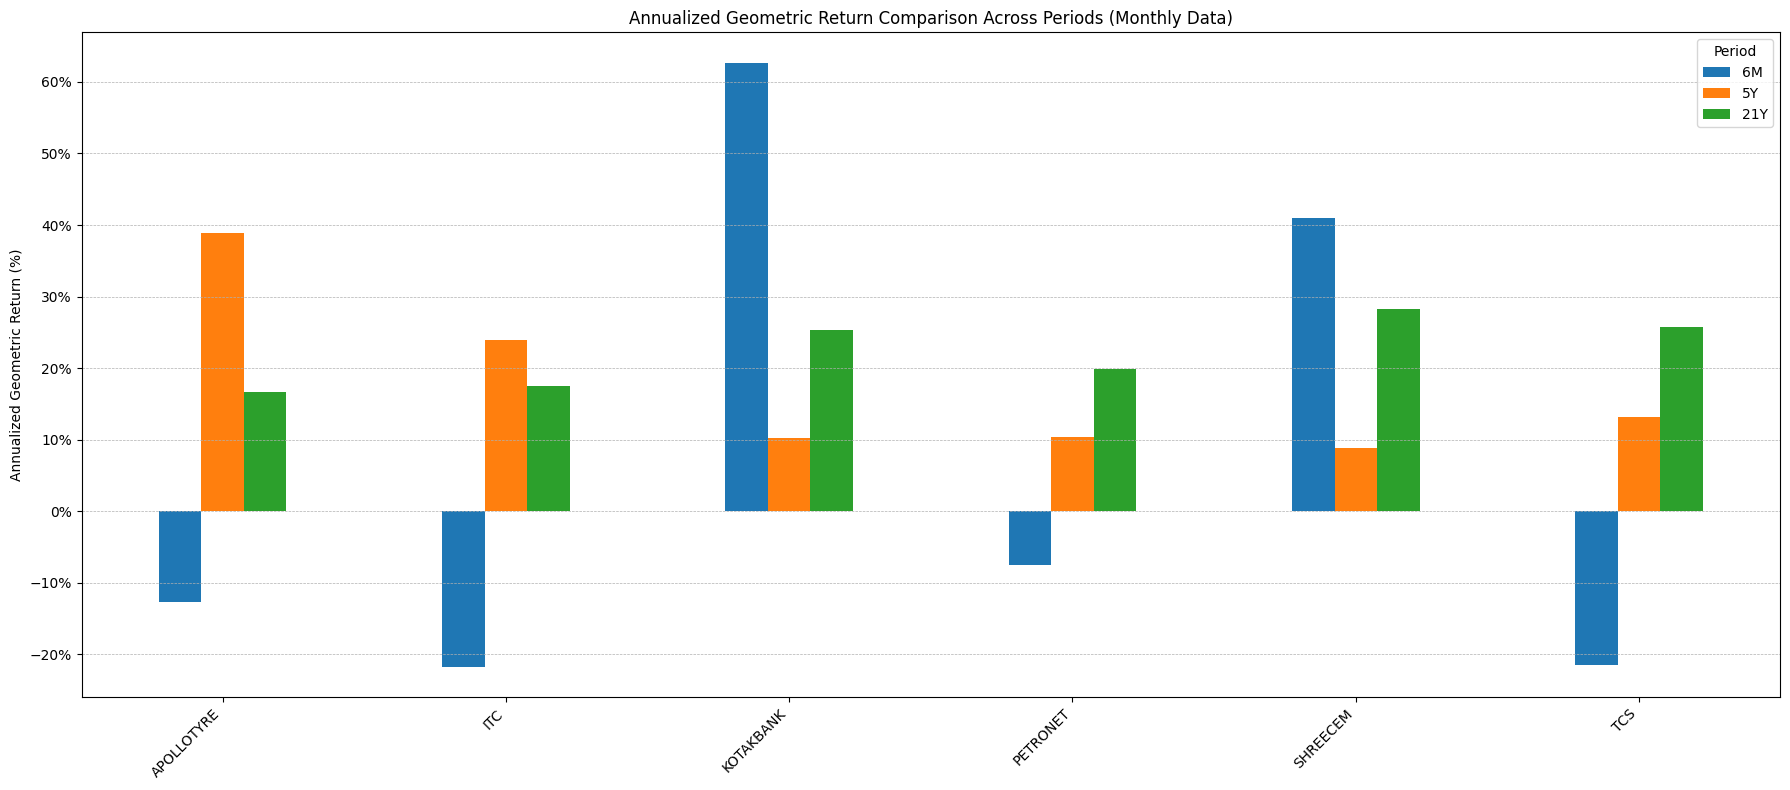

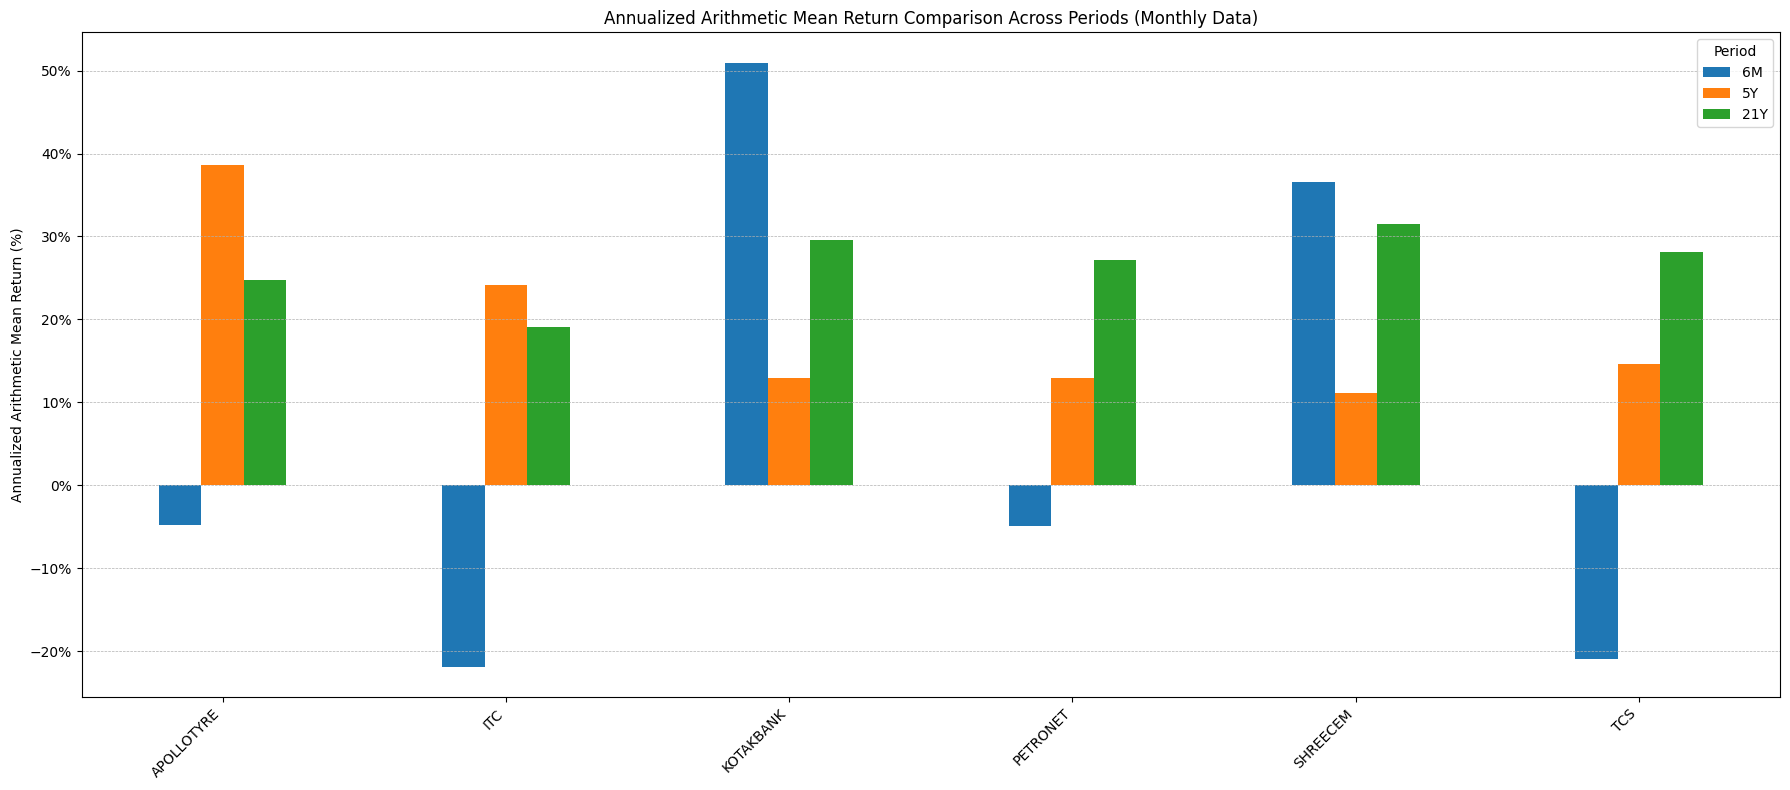

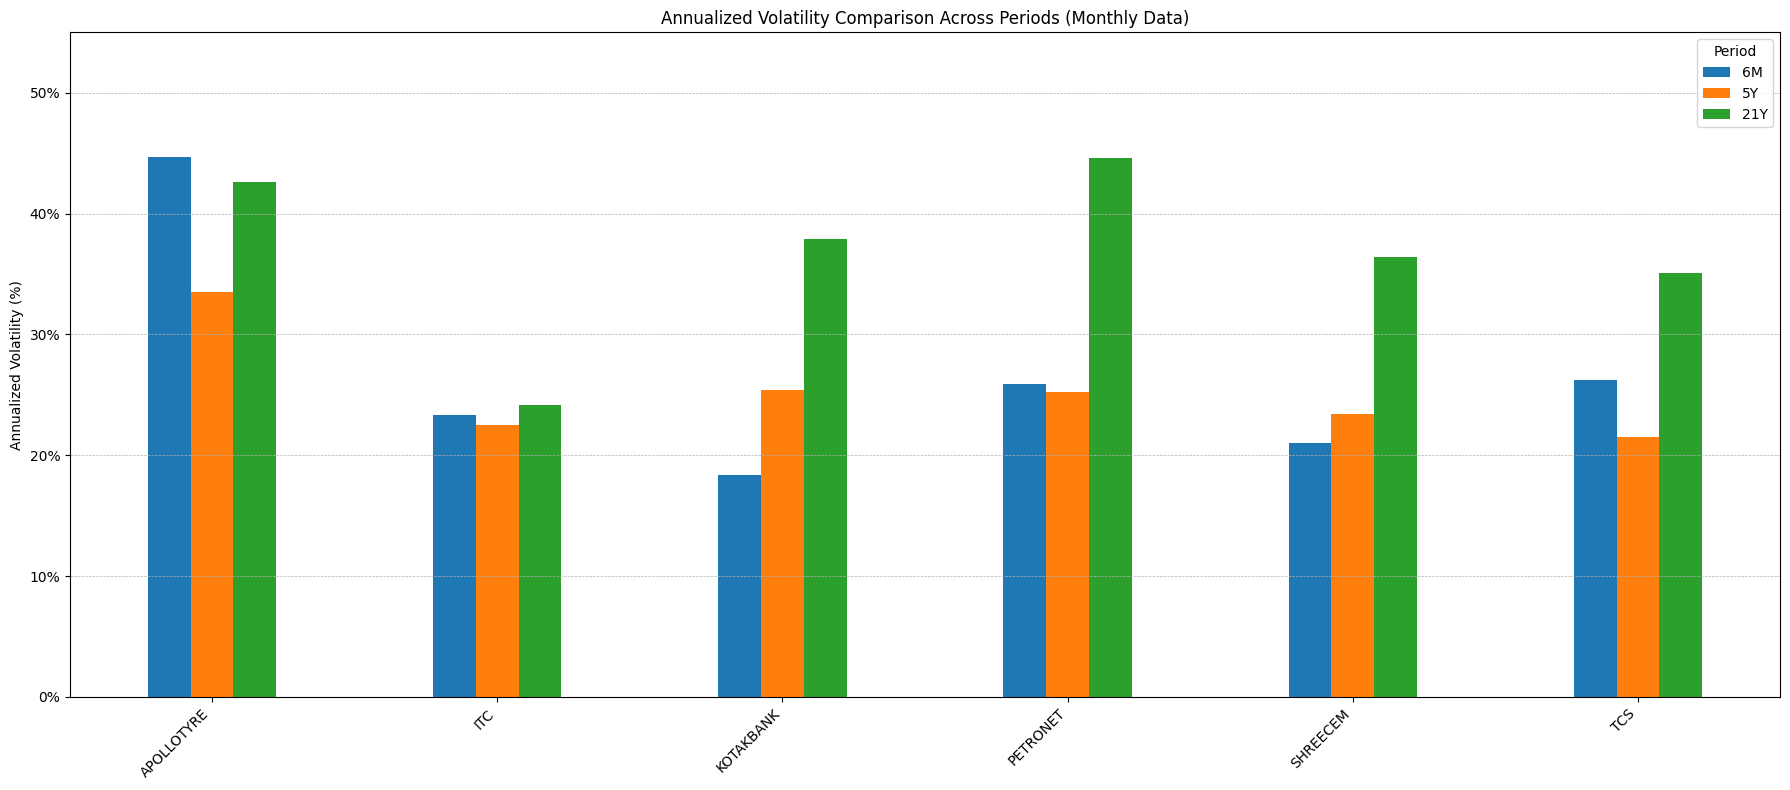

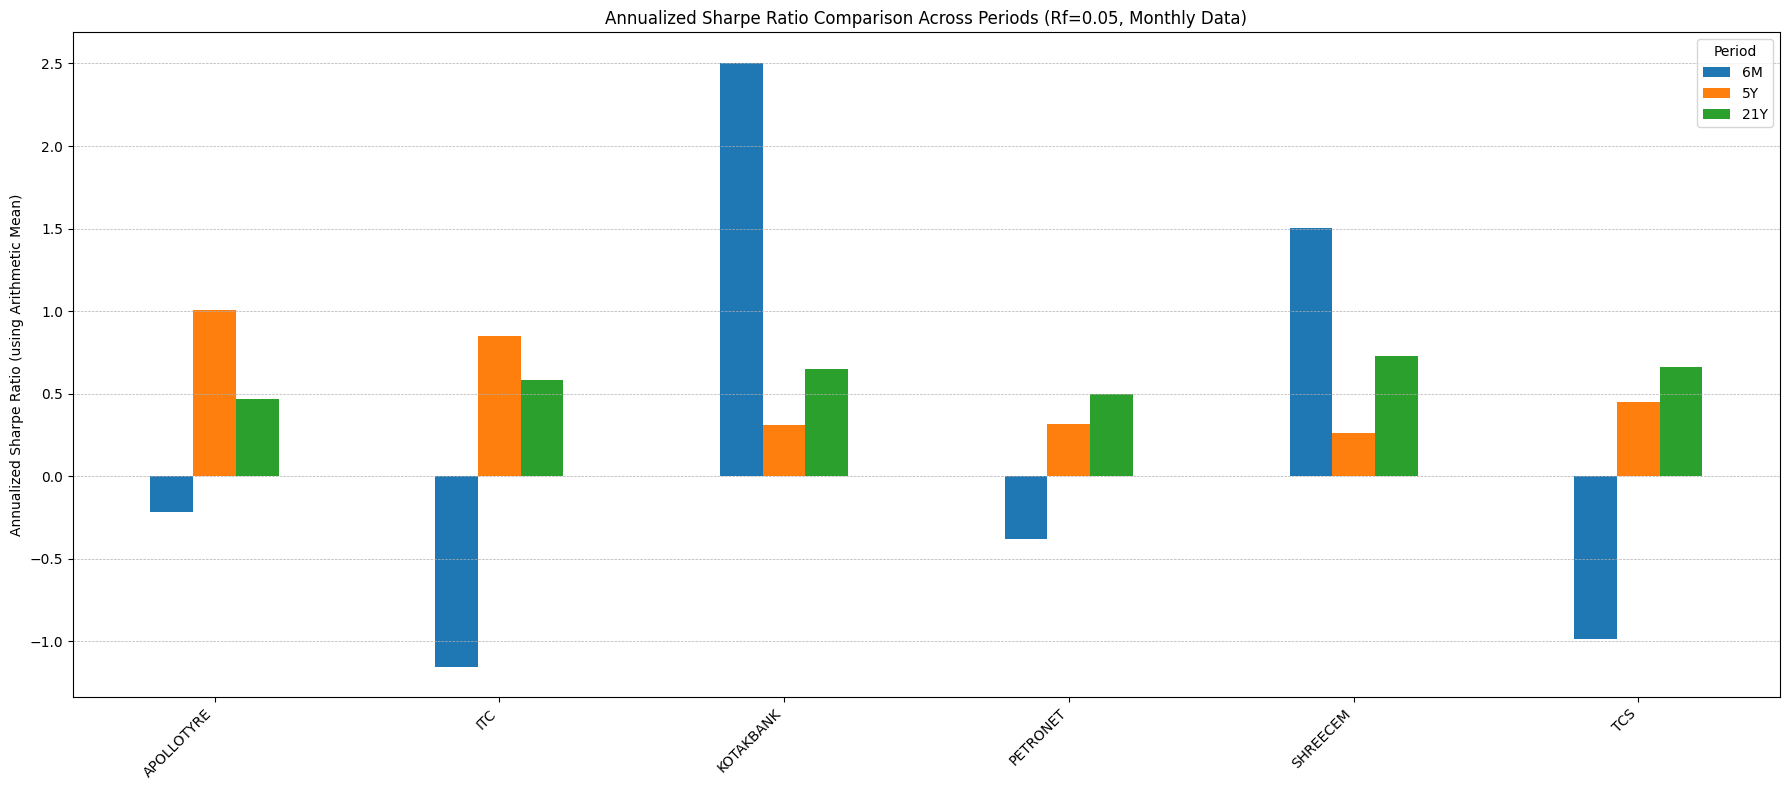

In [105]:
# --- Plotting Financial Statistics Comparison ---

# Use the long format DataFrame for plotting
if not stats_df_long.empty:
    periods = stats_df_long['Period'].unique().tolist()
    assets = stats_df_long['Asset'].unique().tolist()
    num_periods = len(periods)
    num_assets = len(assets)
    bar_width = 0.15 # Adjust width based on number of periods

    # Pivot the long DataFrame back to a wide format suitable for grouped bar plots
    geo_return_pivot = stats_df_long.pivot(index='Asset', columns='Period', values='Annual Geo Return (%)')
    arith_return_pivot = stats_df_long.pivot(index='Asset', columns='Period', values='Annual Arith Return (%)') # Added pivot for Arithmetic Return
    volatility_pivot = stats_df_long.pivot(index='Asset', columns='Period', values='Annual Vol (%)')
    sharpe_pivot = stats_df_long.pivot(index='Asset', columns='Period', values='Annual Sharpe')

    # Ensure pivots are aligned with the symbols order for consistent plotting
    geo_return_pivot = geo_return_pivot.loc[symbols]
    arith_return_pivot = arith_return_pivot.loc[symbols] # Reindex arithmetic pivot
    volatility_pivot = volatility_pivot.loc[symbols]
    sharpe_pivot = sharpe_pivot.loc[symbols]

    # Ensure columns (periods) are in the desired order for plotting
    geo_return_pivot = geo_return_pivot[periods]
    arith_return_pivot = arith_return_pivot[periods] # Reorder arithmetic pivot columns
    volatility_pivot = volatility_pivot[periods]
    sharpe_pivot = sharpe_pivot[periods]


    # 1. Plot Annualized Geometric Return
    plt.figure(figsize=(18, 8))
    x_pos = np.arange(num_assets)

    for i, period in enumerate(periods):
        offset = bar_width * (i - (num_periods - 1) / 2)
        plt.bar(x_pos + offset, geo_return_pivot[period], width=bar_width, label=period)

    plt.xticks(x_pos, [s.replace('.NS', '') for s in symbols], rotation=45, ha='right')
    plt.ylabel('Annualized Geometric Return (%)')
    plt.title(f'Annualized Geometric Return Comparison Across Periods ({period_frequency_name} Data)')
    plt.legend(title="Period", loc='best')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(10))

    plt.tight_layout()
    plt.show()

    # --- Added Plot for Annualized Arithmetic Mean Return ---
    plt.figure(figsize=(18, 8))
    x_pos = np.arange(num_assets)

    for i, period in enumerate(periods):
        offset = bar_width * (i - (num_periods - 1) / 2)
        plt.bar(x_pos + offset, arith_return_pivot[period], width=bar_width, label=period) # Use arithmetic data

    plt.xticks(x_pos, [s.replace('.NS', '') for s in symbols], rotation=45, ha='right')
    plt.ylabel('Annualized Arithmetic Mean Return (%)') # Updated ylabel
    plt.title(f'Annualized Arithmetic Mean Return Comparison Across Periods ({period_frequency_name} Data)') # Updated title
    plt.legend(title="Period", loc='best')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(10)) # Use 10% intervals here too

    plt.tight_layout()
    plt.show()
    # --- End of Added Plot ---


    # 2. Plot Annualized Volatility
    plt.figure(figsize=(18, 8))
    x_pos = np.arange(num_assets)

    for i, period in enumerate(periods):
        offset = bar_width * (i - (num_periods - 1) / 2)
        plt.bar(x_pos + offset, volatility_pivot[period], width=bar_width, label=period)

    plt.xticks(x_pos, [s.replace('.NS', '') for s in symbols], rotation=45, ha='right')
    plt.ylabel('Annualized Volatility (%)')
    plt.title(f'Annualized Volatility Comparison Across Periods ({period_frequency_name} Data)')
    plt.legend(title="Period", loc='best')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Calculate data range and set limits for consistent ticks
    min_vol = volatility_pivot.values.min() if not volatility_pivot.empty else 0
    max_vol = volatility_pivot.values.max() if not volatility_pivot.empty else 10

    ymin = math.floor(min_vol / 10) * 10
    ymax = math.ceil(max_vol / 10) * 10
    if ymax - ymin < 20:
        ymax = ymin + 20
    ymax += 5
    ymin = min(ymin, 0)

    plt.ylim(ymin, ymax)

    plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(10))

    plt.tight_layout()
    plt.show()

    # 3. Plot Annualized Sharpe Ratio
    plt.figure(figsize=(18, 8))
    x_pos = np.arange(num_assets)

    for i, period in enumerate(periods):
        offset = bar_width * (i - (num_periods - 1) / 2)
        plt.bar(x_pos + offset, sharpe_pivot[period], width=bar_width, label=period)

    plt.xticks(x_pos, [s.replace('.NS', '') for s in symbols], rotation=45, ha='right')
    plt.ylabel('Annualized Sharpe Ratio (using Arithmetic Mean)')
    plt.title(f'Annualized Sharpe Ratio Comparison Across Periods (Rf={annual_risk_free_rate:.2f}, {period_frequency_name} Data)')
    plt.legend(title="Period", loc='best')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


else:
    print("\nCannot generate statistics comparison plots: Statistics DataFrame is empty.")


# ## Portfolio Optimization and Random Portfolios (Based on 21-Year Data)
#
Performing optimization and generating random portfolios using the metrics from the 21-year period ending April 30, 2025. These calculations use **arithmetic mean returns** as is standard for Markowitz optimization. The optimization goal is selected in the Configuration section.



In [106]:
# --- Analyze Optimization Period (20 Years) ---
optimization_period_name = f"{optimization_period_years}Y"
try:
    start_date_optimization = stats_start_dates[optimization_period_name]
except KeyError:
    start_date_optimization = end_date - pd.DateOffset(years=optimization_period_years)
    print(f"Warning: Optimization period '{optimization_period_name}' not found in stats_start_dates. Recalculating start date.", )

print(f"\n--- Analyzing {optimization_period_name} Period ({start_date_optimization.date()} to {end_date.date()}) for Optimization ---")

# Slice data for the optimization period
returns_optimization_period = returns_full.loc[start_date_optimization:]

optimal_results = None
random_portfolios_df = None
Avg_period_return_opt_arithmetic = None
cov_period_opt = None
Std_dev_period_opt = None
Avg_annual_return_opt_arithmetic = None
Std_dev_annual_opt = None
single_asset_annual_std_dev_opt = None
selected_optimized_portfolio = None
optimization_goal_name = ""


if not returns_optimization_period.empty and len(returns_optimization_period) >= 2:
    Avg_period_return_opt_arithmetic = returns_optimization_period.mean()
    cov_period_opt = returns_optimization_period.cov()
    Std_dev_period_opt = returns_optimization_period.std()

    Avg_annual_return_opt_arithmetic = Avg_period_return_opt_arithmetic * annualization_factor
    Std_dev_annual_opt = Std_dev_period_opt * np.sqrt(annualization_factor)
    single_asset_annual_std_dev_opt = Std_dev_annual_opt # Individual asset volatility is its standard deviation


    # --- Prepare Weight Bounds for Optimization ---
    if custom_weight_bounds:
        # Create a list of bounds (min, max) for each asset in the symbols list order
        bounds_list = []
        for symbol in symbols:
            if symbol in custom_weight_bounds:
                bounds_list.append(custom_weight_bounds[symbol])
            else:
                # Use the general_weight_bounds as the default if no custom bound is specified for an asset
                bounds_list.append(general_weight_bounds)
        actual_weight_bounds_for_optimization = bounds_list
        print("\nApplying custom weight bounds per asset.")
    else:
        # Use the general_weight_bounds for all assets
        actual_weight_bounds_for_optimization = general_weight_bounds
        print("\nApplying general weight bounds to all assets.")


    # Run optimization to get the efficient frontier and key portfolios
    print("Running portfolio optimization to calculate the efficient frontier...")
    optimal_results = optimize_portfolio(
        returns_df=returns_optimization_period, # Pass the period's returns DataFrame
        risk_free_rate=period_risk_free_rate, # Pass the per-period risk-free rate
        weight_bounds=actual_weight_bounds_for_optimization # Use the prepared bounds
    )

    if optimal_results and not optimal_results['efficient_frontier'].empty:
        print("Optimization complete. Efficient frontier calculated.")
        efficient_frontier_df = optimal_results['efficient_frontier']

        # --- Select Portfolio based on Optimization Goal ---
        if optimization_goal == 1:
            optimization_goal_name = "Maximize Sharpe Ratio"
            selected_optimized_portfolio = optimal_results.get('max_sharpe_portfolio')
            if selected_optimized_portfolio:
                 print(f"\nOptimization Goal: {optimization_goal_name}")
            else:
                 print(f"\nOptimization Goal: {optimization_goal_name} - Could not find Max Sharpe portfolio.")

        elif optimization_goal == 2:
            optimization_goal_name = f"Minimize Volatility for Target Annual Return ({target_annual_return:.2%})"
            target_return_period = target_annual_return / annualization_factor

            above_target = efficient_frontier_df[efficient_frontier_df['return'] >= target_return_period]

            if not above_target.empty:
                selected_optimized_portfolio_row = above_target.loc[above_target['risk'].idxmin()]
                selected_optimized_portfolio = {
                    'weights': dict(zip(symbols, selected_optimized_portfolio_row[[col for col in efficient_frontier_df.columns if col.startswith('weight_')]].values)),
                    'return': selected_optimized_portfolio_row['return'],
                    'risk': selected_optimized_portfolio_row['risk'],
                    'sharpe': selected_optimized_portfolio_row['sharpe']
                }
                print(f"\nOptimization Goal: {optimization_goal_name}")
                print(f"Found portfolio with Annualized Return: {selected_optimized_portfolio['return'] * annualization_factor:.2%}, Annualized Volatility: {selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor):.2%}")
            else:
                print(f"\nOptimization Goal: {optimization_goal_name} - No portfolio found on the efficient frontier with at least {target_annual_return:.2%} annualized return.")
                selected_optimized_portfolio = None


        elif optimization_goal == 3:
            optimization_goal_name = f"Maximize Return for Target Annual Volatility ({target_annual_volatility:.2%})"
            target_volatility_period = target_annual_volatility / np.sqrt(annualization_factor)

            # Find the point on the efficient frontier closest to the target volatility from below
            below_target = efficient_frontier_df[efficient_frontier_df['risk'] <= target_volatility_period]

            if not below_target.empty:
                # Among those, find the one with the maximum return
                selected_optimized_portfolio_row = below_target.loc[below_target['return'].idxmax()]
                selected_optimized_portfolio = {
                    'weights': dict(zip(symbols, selected_optimized_portfolio_row[[col for col in efficient_frontier_df.columns if col.startswith('weight_')]].values)),
                    'return': selected_optimized_portfolio_row['return'],
                    'risk': selected_optimized_portfolio_row['risk'],
                    'sharpe': selected_optimized_portfolio_row['sharpe']
                }
                print(f"\nOptimization Goal: {optimization_goal_name}")
                print(f"Found portfolio with Annualized Volatility: {selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor):.2%}, Annualized Return: {selected_optimized_portfolio['return'] * annualization_factor:.2%}")

            else:
                print(f"\nOptimization Goal: {optimization_goal_name} - No portfolio found on the efficient frontier with at most {target_annual_volatility:.2%} annualized volatility.")
                selected_optimized_portfolio = None


        elif optimization_goal == 4:
            optimization_goal_name = "Minimize Variance"
            selected_optimized_portfolio = optimal_results.get('min_variance_portfolio')
            if selected_optimized_portfolio:
                 print(f"\nOptimization Goal: {optimization_goal_name}")
            else:
                 print(f"\nOptimization Goal: {optimization_goal_name} - Could not find Minimum Variance portfolio.")


        else:
            optimization_goal_name = "Unknown Goal"
            print(f"\nOptimization Goal: Invalid optimization goal ({optimization_goal}) selected. No specific optimized portfolio selected.")
            selected_optimized_portfolio = None


    else:
        print("Portfolio optimization failed or efficient frontier is empty.")


    # Generate random portfolios (always based on the optimization period)
    if Avg_period_return_opt_arithmetic is not None and cov_period_opt is not None:
        print(f"\nGenerating {num_random_portfolios} random portfolios...")
        random_portfolios_df = return_portfolios(Avg_period_return_opt_arithmetic, cov_period_opt, num_random_portfolios)
        if random_portfolios_df is not None:
            random_portfolios_df['Annualized Returns'] = random_portfolios_df['Returns'] * annualization_factor
            random_portfolios_df['Annualized Volatility'] = random_portfolios_df['Volatility'] * np.sqrt(annualization_factor)
            print("Random portfolio generation complete.")
        else:
            print("Failed to generate random portfolios.")

else:
    print(f"Not enough data available for {optimization_period_name} optimization analysis.")



--- Analyzing 21Y Period (2004-04-30 to 2025-04-30) for Optimization ---

Applying custom weight bounds per asset.
Running portfolio optimization to calculate the efficient frontier...
Optimization complete. Efficient frontier calculated.

Optimization Goal: Minimize Volatility for Target Annual Return (29.00%)
Found portfolio with Annualized Return: 29.12%, Annualized Volatility: 24.97%

Generating 1000 random portfolios...
Random portfolio generation complete.


# ## Portfolio Optimization Plot

Visualizing the Efficient Frontier, Minimum Variance Portfolio, Maximum Sharpe Ratio Portfolio, Random Portfolios, and Individual Stocks based on the 21-year data. These are plotted using **annualized arithmetic mean return** and **annualized volatility**. The User Defined Portfolio and the **Selected Optimized Portfolio** (based on your configuration) are also plotted.



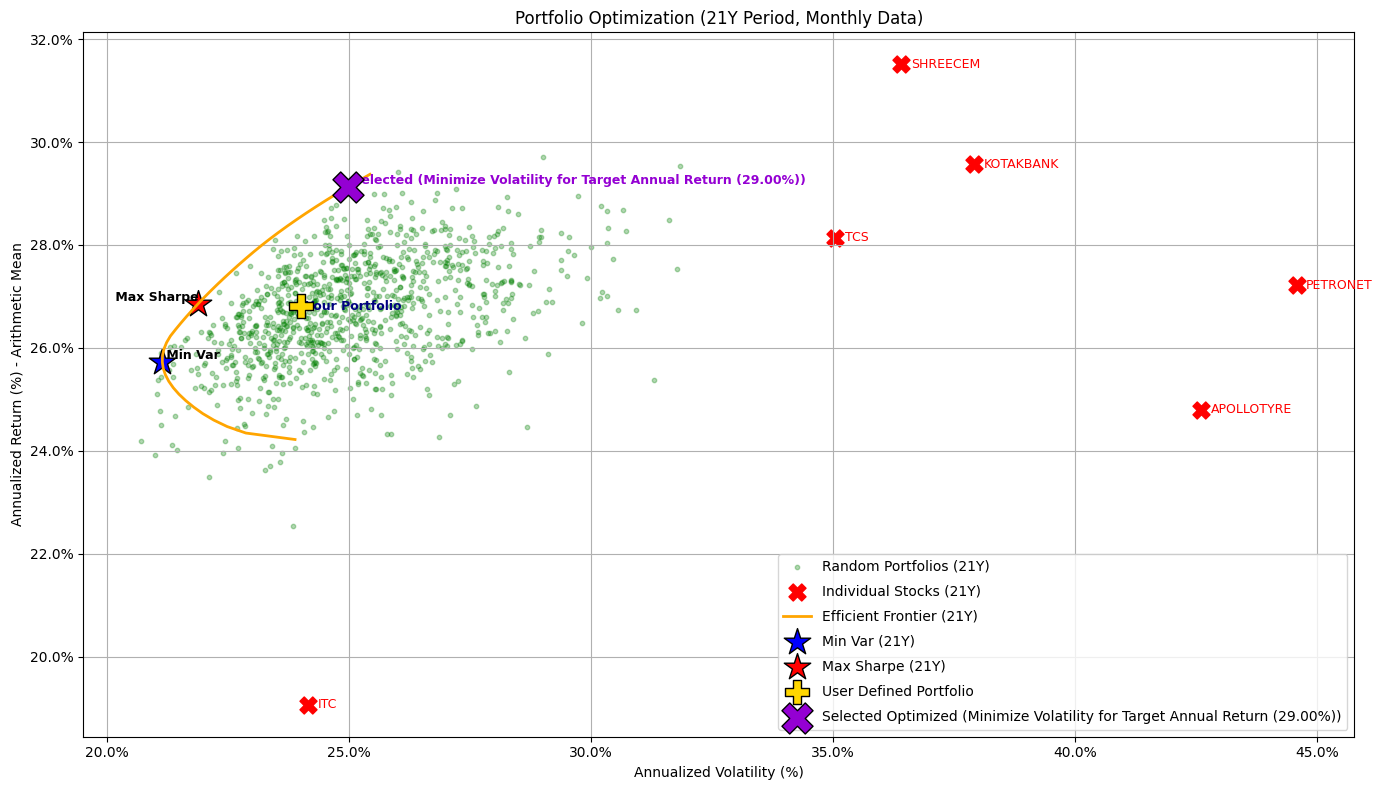

In [107]:
# --- Plotting Efficient Frontier and Portfolios (Based on Optimization Period) ---

if optimal_results or (random_portfolios_df is not None and not random_portfolios_df.empty):
    plt.figure(figsize=(14, 8))

    # Plot Random Portfolios
    if random_portfolios_df is not None and not random_portfolios_df.empty:
        plt.scatter(random_portfolios_df['Annualized Volatility'] * 100,
                    random_portfolios_df['Annualized Returns'] * 100,
                    c='green', alpha=0.3, s=10, label=f'Random Portfolios ({optimization_period_name})')

    # Plot Individual Stocks (using Annualized Arithmetic Mean and Volatility from optimization period)
    if Avg_annual_return_opt_arithmetic is not None and single_asset_annual_std_dev_opt is not None:
        plt.scatter(single_asset_annual_std_dev_opt * 100, Avg_annual_return_opt_arithmetic * 100,
                    marker='X', color='red', s=150, label=f'Individual Stocks ({optimization_period_name})')
        # Add labels for individual stocks
        for i, symbol in enumerate(symbols):
            ann_return = Avg_annual_return_opt_arithmetic.get(symbol, 0) * 100
            ann_vol = single_asset_annual_std_dev_opt.get(symbol, 0) * 100
            plt.text(ann_vol + 0.2, ann_return, symbol.replace('.NS', ''), fontsize=9, ha='left', va='center', color='red')


    # Plot Efficient Frontier (based on arithmetic mean optimization results)
    if optimal_results and not optimal_results['efficient_frontier'].empty:
        efficient_frontier_df = optimal_results['efficient_frontier']
        plt.plot(efficient_frontier_df['risk'] * np.sqrt(annualization_factor) * 100,
                 efficient_frontier_df['return'] * annualization_factor * 100,
                 color='orange', linewidth=2, label=f'Efficient Frontier ({optimization_period_name})')


    # Plot Minimum Variance Portfolio (based on arithmetic mean optimization results)
    if optimal_results and optimal_results['min_variance_portfolio']:
        min_var = optimal_results['min_variance_portfolio']
        plt.scatter(min_var['risk'] * np.sqrt(annualization_factor) * 100,
                    min_var['return'] * annualization_factor * 100,
                    marker='*', color='blue', s=400, label=f'Min Var ({optimization_period_name})', edgecolors='black')
        # Add label
        plt.text(min_var['risk'] * np.sqrt(annualization_factor) * 100,
                 min_var['return'] * annualization_factor * 100,
                 ' Min Var', fontsize=9, ha='left', va='bottom', weight='bold')


    # Plot Maximum Sharpe Ratio Portfolio (based on arithmetic mean optimization results)
    if optimal_results and optimal_results['max_sharpe_portfolio']:
         max_sharpe = optimal_results['max_sharpe_portfolio']
         plt.scatter(max_sharpe['risk'] * np.sqrt(annualization_factor) * 100,
                     max_sharpe['return'] * annualization_factor * 100,
                     marker='*', color='red', s=400, label=f'Max Sharpe ({optimization_period_name})', edgecolors='black')
         # Add label
         plt.text(max_sharpe['risk'] * np.sqrt(annualization_factor) * 100,
                  max_sharpe['return'] * annualization_factor * 100,
                  ' Max Sharpe', fontsize=9, ha='right', va='bottom', weight='bold')


    # Plot User Defined Portfolio (Based on Annualized Arithmetic Mean and Volatility from optimization period)
    user_return_annual_arithmetic = None
    user_volatility_annual = None

    if Avg_period_return_opt_arithmetic is not None and cov_period_opt is not None and \
       all(asset in user_defined_weights for asset in symbols) and abs(sum(user_defined_weights.values()) - 1.0) < 1e-9:
        try:
             user_weights_array = np.array([user_defined_weights.get(asset, 0) for asset in symbols])
             user_return_period_arithmetic = np.dot(user_weights_array, Avg_period_return_opt_arithmetic)
             user_volatility_period = np.sqrt(np.dot(user_weights_array.T, np.dot(cov_period_opt, user_weights_array)))

             user_return_annual_arithmetic = user_return_period_arithmetic * annualization_factor
             user_volatility_annual = user_volatility_period * np.sqrt(annualization_factor)

             plt.scatter(user_volatility_annual * 100, user_return_annual_arithmetic * 100,
                         marker='P', color='gold', s=300, label='User Defined Portfolio', edgecolors='black', zorder=5)

             plt.text(user_volatility_annual * 100, user_return_annual_arithmetic * 100,
                      ' Your Portfolio', fontsize=9, ha='left', va='center', weight='bold', color='navy')

        except Exception as e:
            print(f"Error calculating or plotting User Defined Portfolio: {e}")
    else:
         if not (all(asset in user_defined_weights for asset in symbols) and abs(sum(user_defined_weights.values()) - 1.0) < 1e-9):
             print("User Defined Weights are invalid (check symbols and sum to 1) - skipping plot.")
         elif Avg_period_return_opt_arithmetic is None or cov_period_opt is None:
              print("Cannot plot User Defined Portfolio as data for the optimization period is not available.")

    # Plot the Selected Optimized Portfolio
    if selected_optimized_portfolio:
        plt.scatter(selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor) * 100,
                    selected_optimized_portfolio['return'] * annualization_factor * 100,
                    marker='X', color='darkviolet', s=500, label=f'Selected Optimized ({optimization_goal_name})', edgecolors='black', zorder=6)
        # Add label
        plt.text(selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor) * 100,
                 selected_optimized_portfolio['return'] * annualization_factor * 100,
                 f' Selected ({optimization_goal_name})', fontsize=9, ha='left', va='bottom', weight='bold', color='darkviolet')


    plt.xlabel('Annualized Volatility (%)')
    plt.ylabel('Annualized Return (%) - Arithmetic Mean')
    plt.title(f'Portfolio Optimization ({optimization_period_name} Period, {period_frequency_name} Data)')
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend(labelspacing=0.8, loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nNot enough data or optimization results to generate the portfolio optimization plot.")


# ## Portfolio Comparison Table (Based on 21-Year Metrics)
Comparing the Minimum Variance, Maximum Sharpe Ratio, User Defined, and the **Selected Optimized Portfolio** based on their metrics calculated using the **arithmetic mean returns** from the 20-year period.



In [108]:
# --- Prepare and Display Portfolio Comparison Table (for Optimization Period) ---

print(f"\n--- Portfolio Comparison (Based on {optimization_period_name} Period Arithmetic Metrics) ---")

portfolio_summaries_opt = []

# Use metrics from the optimization period (based on arithmetic mean)
if optimal_results:
    # Add Minimum Variance Portfolio summary
    if optimal_results['min_variance_portfolio']:
        min_var = optimal_results['min_variance_portfolio']
        min_var_sharpe_annual = (min_var['return'] * annualization_factor - annual_risk_free_rate) / (min_var['risk'] * np.sqrt(annualization_factor)) if (min_var['risk'] * np.sqrt(annualization_factor)) > 0 else np.nan
        portfolio_summaries_opt.append({
            'Portfolio Type': f'Minimum Variance ({optimization_period_name})',
            'Annualized Return (%)': min_var['return'] * annualization_factor * 100,
            'Annualized Volatility (%)': min_var['risk'] * np.sqrt(annualization_factor) * 100,
            'Sharpe Ratio (Annualized)': min_var_sharpe_annual,
            'Weights': min_var['weights']
        })

    # Add Maximum Sharpe Ratio Portfolio summary
    if optimal_results['max_sharpe_portfolio']:
        max_sharpe = optimal_results['max_sharpe_portfolio']
        max_sharpe_sharpe_annual = (max_sharpe['return'] * annualization_factor - annual_risk_free_rate) / (max_sharpe['risk'] * np.sqrt(annualization_factor)) if (max_sharpe['risk'] * np.sqrt(annualization_factor)) > 0 else np.nan
        portfolio_summaries_opt.append({
            'Portfolio Type': f'Maximum Sharpe ({optimization_period_name})',
            'Annualized Return (%)': max_sharpe['return'] * annualization_factor * 100,
            'Annualized Volatility (%)': max_sharpe['risk'] * np.sqrt(annualization_factor) * 100,
            'Sharpe Ratio (Annualized)': max_sharpe_sharpe_annual,
            'Weights': max_sharpe['weights']
        })

    # Add User Defined Portfolio summary
    user_return_annual_arithmetic = None
    user_volatility_annual = None

    if Avg_period_return_opt_arithmetic is not None and cov_period_opt is not None and \
       all(asset in user_defined_weights for asset in symbols) and abs(sum(user_defined_weights.values()) - 1.0) < 1e-9:
        try:
            user_weights_array = np.array([user_defined_weights.get(asset, 0) for asset in symbols])
            user_return_period_arithmetic = np.dot(user_weights_array, Avg_period_return_opt_arithmetic)
            user_volatility_period = np.sqrt(np.dot(user_weights_array.T, np.dot(cov_period_opt, user_weights_array)))

            user_return_annual_arithmetic = user_return_period_arithmetic * annualization_factor
            user_volatility_annual = user_volatility_period * np.sqrt(annualization_factor)
            user_sharpe_annual = (user_return_annual_arithmetic - annual_risk_free_rate) / user_volatility_annual if user_volatility_annual > 0 else np.nan

            portfolio_summaries_opt.append({
                'Portfolio Type': 'User Defined',
                'Annualized Return (%)': user_return_annual_arithmetic * 100,
                'Annualized Volatility (%)': user_volatility_annual * 100,
                'Sharpe Ratio (Annualized)': user_sharpe_annual,
                'Weights': user_defined_weights
            })
        except Exception as e:
             print(f"Error adding User Defined Portfolio to table: {e}")
    else:
         print("User Defined Portfolio metrics not available for table.")

    # Add the Selected Optimized Portfolio summary
    if selected_optimized_portfolio:
         selected_sharpe_annual = (selected_optimized_portfolio['return'] * annualization_factor - annual_risk_free_rate) / (selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor)) if (selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor)) > 0 else np.nan
         portfolio_summaries_opt.append({
             'Portfolio Type': f'Selected Optimized ({optimization_goal_name})',
             'Annualized Return (%)': selected_optimized_portfolio['return'] * annualization_factor * 100,
             'Annualized Volatility (%)': selected_optimized_portfolio['risk'] * np.sqrt(annualization_factor) * 100,
             'Sharpe Ratio (Annualized)': selected_sharpe_annual,
             'Weights': selected_optimized_portfolio['weights']
         })


    # Create DataFrame
    if portfolio_summaries_opt:
        comparison_df_opt = pd.DataFrame(portfolio_summaries_opt)

        # Expand the 'Weights' column into separate columns for each asset
        weights_data = []
        for summary in portfolio_summaries_opt:
            weights_row = {f'{asset} Weight': summary['Weights'].get(asset, 0) for asset in symbols}
            weights_data.append(weights_row)
        weights_df_opt = pd.DataFrame(weights_data)


        # Drop the original 'Weights' column and join the new ones
        comparison_df_opt = comparison_df_opt.drop(columns=['Weights'])
        comparison_df_opt = pd.concat([comparison_df_opt, weights_df_opt], axis=1)

        # Set 'Portfolio Type' as index for cleaner display
        comparison_df_opt = comparison_df_opt.set_index('Portfolio Type')

        # Display the comparison DataFrame using display()
        print("\n--- Portfolio Comparison (Based on 20Y Period Arithmetic Metrics) ---")
        format_dict_comp = {col: '{:.4f}'.format for col in comparison_df_opt.columns if 'Weight' in col}
        format_dict_comp.update({col: '{:.2f}%'.format for col in comparison_df_opt.columns if 'Return (%)' in col or 'Volatility (%)' in col})
        format_dict_comp.update({col: '{:.2f}'.format for col in comparison_df_opt.columns if 'Sharpe' in col})

        styled_comparison_df_opt = comparison_df_opt.style.format(format_dict_comp)
        display(styled_comparison_df_opt)

    else:
        print("No portfolio summaries to display for the optimization period.")

else:
    print("Cannot perform portfolio comparison table as data for the optimization period is not available or optimization failed.")



--- Portfolio Comparison (Based on 21Y Period Arithmetic Metrics) ---

--- Portfolio Comparison (Based on 20Y Period Arithmetic Metrics) ---


,Annualized Return (%),Annualized Volatility (%),Sharpe Ratio (Annualized),APOLLOTYRE.NS Weight,ITC.NS Weight,KOTAKBANK.NS Weight,PETRONET.NS Weight,SHREECEM.NS Weight,TCS.NS Weight
Portfolio Type,,,,,,,,,
Minimum Variance (21Y),25.73%,21.14%,0.98,0.0650,0.3000,0.1087,0.0911,0.1353,0.3000
Maximum Sharpe (21Y),26.86%,21.88%,1.00,0.0001,0.2483,0.1453,0.0622,0.2440,0.3000
User Defined,26.81%,24.00%,0.91,0.1600,0.1600,0.1700,0.1700,0.1700,0.1700
Selected Optimized (Minimize Volatility for Target Annual Return (29.00%)),29.12%,24.97%,0.97,0.0000,0.0376,0.2747,0.0877,0.3000,0.3000
